# Handwritten Letter Recognition with EMNIST

This notebook accepts a handwritten letter image upload and predicts the letter (A-Z) using a CNN trained on the EMNIST Letters dataset.


In [8]:
%pip install tensorflow tensorflow_datasets -q


Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [10]:
# Step 1: Select image
# For Colab: uses file upload widget
# For local: set the path manually below

try:
    from google.colab import files
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]
except ModuleNotFoundError:
    # Running locally - set your image path here
    image_path = "img061-042.png"  # <-- CHANGE THIS to your image path
    print(f"Using local file: {image_path}")

Using local file: img061-042.png


Image shape: (1, 28, 28, 1)


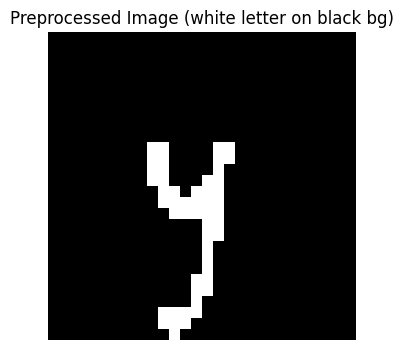

In [11]:
# Step 2: Preprocess uploaded image
img = keras.utils.load_img(image_path, color_mode="grayscale", target_size=(28, 28))
img = keras.utils.img_to_array(img).squeeze()

# Invert colors: uploaded = dark letter on white bg, EMNIST = white letter on black bg
img = 255 - img

# Normalize to 0-1
img = img / 255.0

# Reshape for model: (28, 28) -> (1, 28, 28, 1)
img = img.reshape(1, 28, 28, 1)

print(f"Image shape: {img.shape}")
plt.figure(figsize=(4, 4))
plt.imshow(img[0, :, :, 0], cmap='gray')
plt.title('Preprocessed Image (white letter on black bg)')
plt.axis('off')
plt.show()

In [12]:
# Step 3: Load or train EMNIST Letters model
import os

MODEL_PATH = 'emnist_letters_model.keras'
LETTERS = [chr(i) for i in range(ord('A'), ord('Z')+1)]

def preprocess_emnist(image, label):
    # EMNIST images are rotated 90° CCW and flipped - correct to natural orientation
    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)
    image = tf.cast(image, tf.float32) / 255.0
    label = label - 1  # Labels are 1-26, convert to 0-25
    return image, label

def build_model():
    return keras.Sequential([
        keras.layers.Input(shape=(28, 28, 1)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(26, activation='softmax')
    ])

if os.path.exists(MODEL_PATH):
    print("Loading saved model...")
    model = keras.models.load_model(MODEL_PATH)
else:
    print("Training new model on EMNIST Letters...")
    
    ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)
    
    train_ds = ds_train.map(preprocess_emnist).shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)
    test_ds = ds_test.map(preprocess_emnist).batch(128).prefetch(tf.data.AUTOTUNE)
    
    model = build_model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    print("Training (~5-10 min on Colab GPU)...")
    model.fit(train_ds, epochs=10, validation_data=test_ds)
    
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\nTest accuracy: {test_acc:.2%}")
    
    model.save(MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")


Training new model on EMNIST Letters...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/kyle-anthonyhay/tensorflow_datasets/emnist/letters/incomplete.PJBFNV_3.1.0/emnist-train.tfrec…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/kyle-anthonyhay/tensorflow_datasets/emnist/letters/incomplete.PJBFNV_3.1.0/emnist-test.tfreco…

Dataset emnist downloaded and prepared to /Users/kyle-anthonyhay/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.
Training (~5-10 min on Colab GPU)...
Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6897 - loss: 1.0249 - val_accuracy: 0.8648 - val_loss: 0.4174
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8341 - loss: 0.5289 - val_accuracy: 0.8949 - val_loss: 0.3241
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8617 - loss: 0.4393 - val_accuracy: 0.9022 - val_loss: 0.2949
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8761 - loss: 0.3864 - val_accuracy: 0.9085 - val_loss: 0.2768
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8869 - loss: 0.3520 - val_accuracy: 0.9117 - val_loss: 0.2645
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8959 - loss: 0.3234 - val_accuracy: 0.9155 - val_loss: 0.2581
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/st

In [13]:
# Step 4: Make prediction
predictions = model.predict(img, verbose=0)
predicted_idx = np.argmax(predictions[0])
predicted_letter = LETTERS[predicted_idx]
confidence = predictions[0][predicted_idx]

print(f"Predicted Letter: {predicted_letter}")
print(f"Confidence: {confidence:.2%}")
print("\nTop 5 predictions:")
top_5 = np.argsort(predictions[0])[-5:][::-1]
for idx in top_5:
    print(f"  {LETTERS[idx]}: {predictions[0][idx]:.2%}")


Predicted Letter: Y
Confidence: 51.43%

Top 5 predictions:
  Y: 51.43%
  G: 23.23%
  Q: 16.18%
  U: 1.67%
  V: 1.51%


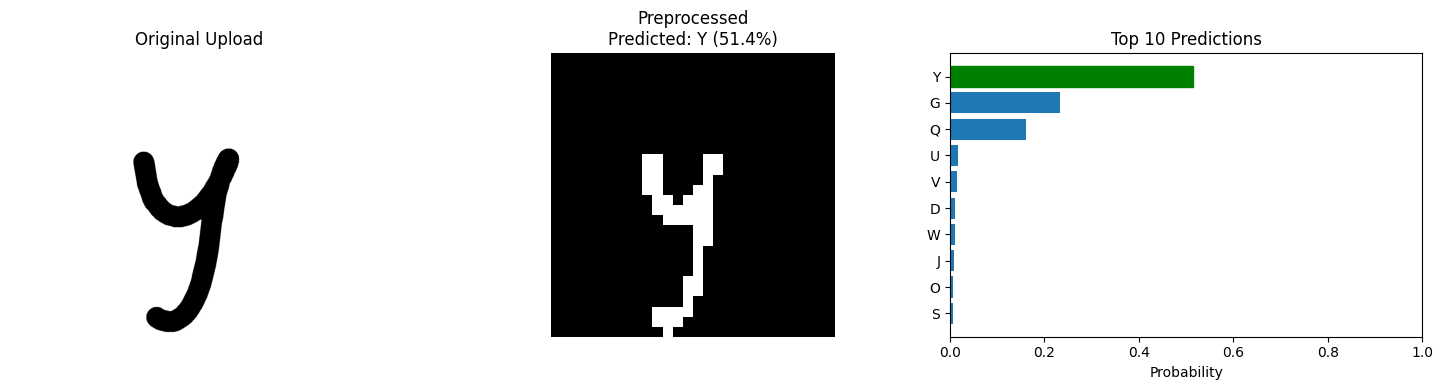

In [14]:
# Step 5: Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original uploaded image
original = keras.utils.load_img(image_path)
axes[0].imshow(original)
axes[0].set_title('Original Upload')
axes[0].axis('off')

# Preprocessed image
axes[1].imshow(img[0, :, :, 0], cmap='gray')
axes[1].set_title(f'Preprocessed\nPredicted: {predicted_letter} ({confidence:.1%})')
axes[1].axis('off')

# Top 10 predictions bar chart
top_10 = np.argsort(predictions[0])[-10:][::-1]
bars = axes[2].barh([LETTERS[i] for i in top_10], [predictions[0][i] for i in top_10])
bars[0].set_color('green')
axes[2].set_xlabel('Probability')
axes[2].set_title('Top 10 Predictions')
axes[2].invert_yaxis()
axes[2].set_xlim(0, 1)

plt.tight_layout()
plt.show()
